In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import h5py
from py15sacla import hdfselection
from glob import glob

%matplotlib inline

## create test data

In [2]:
runs = 52 + np.arange(10)
tags_per_run = 500
start_tag = 4923
background = 42
t_start = -5
t_end = 10

tags = [['{:d}'.format(i+start_tag+j*tags_per_run) for i in range(tags_per_run)]
        for j, _ in enumerate(runs)]

tags_flat = [tag for tagset in tags for tag in tagset]

delays = np.array([t_start + rand(tags_per_run) * (t_end - t_start)
                   for _ in runs])

delays_flat = delays.flatten()

def peak(X, Y, t):
    I0 = np.exp(-t)
    if t <0:
        I0 = 1
    
    I = 100 * I0 * np.exp( -np.sqrt((X-70)**2 + (Y-80)**2)/20)
    for _ in range(5):
        I[int(I.shape[0]*rand(1)),int(I.shape[1]*rand(1))] += 200
        I[int(I.shape[0]*rand(1)),int(I.shape[1]*rand(1))] -= 300
    return I

Y, X = np.meshgrid(np.arange(200), np.arange(330))
background = X*0 + 42.


for run, tagset, delayset in zip(runs, tags, delays):
    with h5py.File('run_{}.h5'.format(run), 'w') as h5file:
        h5file.create_dataset('life_universe_everything', data=42)
        for tag, delay in zip(tagset, delayset):
            h5file.create_dataset('run_{}/detector/tag_{}'.format(run, tag),
                                  data=peak(X, Y, delay) + background)
        h5file.close()

## Define processing timing backgroud thresholds

In [3]:
thresholds = (0, 200)
tophotons = 1
ROI = np.s_[30:130, 20:120]
delays_bin_edges = np.arange(t_start, t_end, 0.5)
delays_bin_centers = (delays_bin_edges[:-1] + delays_bin_edges[1:])/2

## select some tags

In [4]:
h5sel_all = [hdfselection.HDFSelection(filename, 'r')['/detector/']
             for filename in glob("run_*.h5")]
                                      
def filter_tags(hdfsel, delay_start, delay_end, tags_flat, delays_flat):
    hdfout = hdfsel.copy()
    tags_to_get = [tag for tag, delay in zip(tags_flat, delays_flat)
                   if delay_start < delay <= delay_end]
    hdfout._datanames = [n for n in hdfout._datanames
                if any(d in n for d in tags_to_get)]
    return hdfout


h5sels_delays = [[filter_tags(hdfsel, delay_start, delay_end, tags_flat, delays_flat)
                 for hdfsel in h5sel_all]
                for delay_start, delay_end in zip(delays_bin_edges[:-1], delays_bin_edges[1:])]

#images = np.array([h.value for h5sel in h5sel_tags for h in h5sel])

In [5]:
def correct_frame(frame, background, thresholds, ROI, tophotons):
    frame -= background
    frame = frame[ROI]
    frame[frame<thresholds[0]] = 0
    frame[frame>thresholds[1]] = 0
    frame *= tophotons
    return frame
    
def h5sel_to_image(h5sel, background, thresholds, ROI, tophotons):
    if len(h5sel) >1:
        image = sum(correct_frame(HDF5_dataset, background, thresholds, ROI, tophotons)
                    for HDF5_dataset in h5sel.datasets) / len(h5sel)
    else:
        raise Warning("Check if there are delays in this bin. Returning Nan")
        image = np.NaN
        
    return image

images = np.array([sum(h5sel_to_image(h5sel, background, thresholds, ROI, tophotons)
                       for h5sel in h5sels) / len(h5sels)
                   for h5sels in h5sels_delays])



## confirm this worked

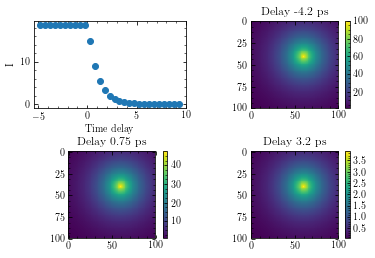

In [6]:
fig, axs = plt.subplots(2,2)

axs[0,0].plot(delays_bin_centers, images.mean(axis=(1,2)), 'o')
axs[0,0].set_xlabel('Time delay')
axs[0,0].set_ylabel('I')

for ax, choose in zip([ax for ax in axs.ravel() if ax is not axs[0,0]], [1, 11, 16]):
    art = ax.imshow(images[choose])
    plt.colorbar(art, ax=ax)
    ax.set_title("Delay {:.2} ps".format(delays_bin_centers[choose]))

fig.subplots_adjust(hspace=0.5)